Including the classes from the lecture. First the potential:

In [1]:
import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat

And then the TwoBody class:

In [2]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of two-body solver. 
        
           The initialization defines the momentum grids and the interaction and partial wave to be used. 
           At this time, also the grid for Fourier transformation and for the Fourier transformed 
           wave function is given. 
           
           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb] 
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           mred -- reduces mass of the two bosons in MeV
           
           nr1 -- number of r points in interval [0,rb] 
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""
        
        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2 
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.l=l 

        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2 
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four 

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)
 
        # store grid points and weights for r space wave functions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)
        
        # store grid points and weights for Fourier trafo 
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)
        
        # store underlying interaction
        self.pot=pot
        
    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gaus-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight 

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # set up the matrix amat for which eigenvalues have to be calculated 
      amat=np.empty((self.npoints,self.npoints),dtype=np.double)
      for i in range(self.npoints):
        for j in range(self.npoints): 
          amat[i,j]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))*self.pot.v(self.pgrid[i],self.pgrid[j],self.l)*self.pweight[j]*self.pgrid[j]**2)

    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(amat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    # define solution as unnormalized wave function 
      wf=evec[:,maxpos]
    # and normalize 
      norm=np.sum(wf**2*self.pweight[0:self.npoints]*self.pgrid[0:self.npoints]**2)
      wf=1/np.sqrt(norm)*wf
    
      return eigv,self.pgrid[0:self.npoints],wf

    
    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
            
        return e1,eta1,pgrid,wf 
           
    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.
        
           Parameter: 
           wfp -- wave function in momentum space
            
           Note that the factor I**l is omitted."""
        
        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points  
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        # evaluate jl     
        jlmat = spherical_jn(self.l,rpmat)
        
        # interpolate of wave to denser Fourier trafo grid
        wfinter = interp1d(self.pgrid, wfp, kind='cubic',fill_value="extrapolate")
        # interpolate wf and multiply my p**2*w elementwise 
        wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)
        
        # now the Fourier trafo is a matrix-vector multiplication 
        wfr = jlmat.dot(wfdense)
        
        return self.rgrid,wfr
    
    
    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.
        
           Normalization of the wave function is assumed. 
           Parameter: 
           wfr -- wave function in r-space obtained by previous Fourier trafo"""
        
        
        norm=np.sum(wfr**2*self.rweight*self.rgrid**2)
        rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

            
        rms=np.sqrt(rms)
        
        return norm,rms

In [3]:
import numpy as np
import math as m
import pandas as pd
from lmfit.models import ExpressionModel 
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.special import sph_harm
from scipy.special import spherical_jn
from scipy.integrate import simps
from scipy.integrate import quad

# Homework 6 from Martin Gräf and Richard Baumann

In this homework we look at a Multigrid simulation of the Gaussian model. A hamiltonian for that problem is given by:

First we put in the class, which was defined in the classwork:


## 1. Confirm that the form factor can be obtained based on the internal wave functions as

\begin{equation}
    F(q^2)=\int d^3p' \psi^*(\vec{p}') \psi \left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)
\end{equation}



First we need to think about the background of the formfactor. This formfactor is calculated assuming a reaction where our two body system is hit by a photon. According to the exercise sheet this porblem is to be solved in the Breit frame, where we only have momentum transfer. 

## 2 Express this relation in terms of partial wave amplitudes. In order to simplify the expression, you can assume that ~ q = q $ \hat{q}_z $ and that only the partial wave $ ll_z $ contributes to the bound state wave function. In this case, $ l_z $ is conserved and the solid angle integration can be simplified to the integration over x = cos(θ). Verify the relation:

\begin{equation}
    F(q^2)= 2\pi \int dp' p'^2 \int_{-1}^{1}dx Y_{ll_z}^{*} (p') Y_{ll_z}^{*} \left(|\vec{p}'-\frac{1}{2}\vec{q} |\right) \psi_{ll_z}^{*} (p') \psi_{ll_z}^{*}      \left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)
\end{equation}


We can use the partial wave decomposition to reduce the dimensionality of the problem:

\begin{equation}
    \psi(\vec{p}')=\sum_{lm} \psi_{lm}(\vec{p}')Y_{lm}(\hat{\vec{p}'})
\end{equation}

Therefore we get:

\begin{equation}
    F(q^2)=\int d^3p' \sum_{lm} \psi_{lm}(\vec{p}')Y_{lm}(\hat{\vec{p}'})\psi_{lm}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)Y_{lm}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)
\end{equation}

In order to simplify the expression, you can assume that $\vec{q} = qe_z$ and that only the partial wave $ll_z$ contributes to the bound state wave function. Thus, our equation changes to:

\begin{equation}
    F(q^2)=\int d^3p' \psi_{ll_z}(\vec{p}')Y_{ll_z}(\hat{\vec{p}'})\psi_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)Y_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)
\end{equation}

Rewriting the problem into spherical coordinates gives us:

\begin{equation}
    F(q^2)=\int dp' \int_0^{2\pi} d\phi \int_{-1}^{1} d\cos(\theta) p'^2 \psi_{ll_z}(\vec{p}')Y_{ll_z}(\hat{\vec{p}'})\psi_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)Y_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)
\end{equation}

Further simplifications show, that:

\begin{equation}
    F(q^2)=2 \pi \int dp' p'^2 \int_{-1}^{1} d\cos(\theta)  \psi_{ll_z}(\vec{p}')Y_{ll_z}(\hat{\vec{p}'})\psi_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)Y_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right) *\cos(\theta)
\end{equation}

We can substitute $\cos(\theta)$:

\begin{equation}
    x=\cos(\theta) \Rightarrow  \frac{dx}{d\cos(\theta)}=1 
\end{equation}

So we can use $\cos(\theta)$ without changing anything:

\begin{equation}
    F(q^2)=2 \pi \int dp' p'^2 \int_{-1}^{1} dx  \psi_{ll_z}(\vec{p}')Y_{ll_z}(\hat{\vec{p}'})\psi_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)Y_{ll_z}\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)
\end{equation}

## 3: Implement the form factor based on the wave functions obtained in the lecture that are defined on a finite grid (you may extend the notebook provided and reuse the TwoBody class). Hint: the wave function $ \phi_{ll_z} (| \vec{p}' − 1/2 \vec{q} | ) $ at momenta different from the momentum grid can be obtained using (cubic) splines. Argument of the spherical harmonic $\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)$ is easiest obtained in terms of its x and z component. How do you get the angles from these components?

Instead of calculating the results using the two body class and potential, we use the given data, which can be found in the folder "Data". For that we need a routine to import the data from the .dat files. For that we use pandas.

In [4]:
def get_values(lamda):
    string="data/wf-obe-lam=" + str(lamda) + ".00.dat"
    data=pd.read_csv(string, sep="  ", skiprows = 2, names = ["p [fm-1]", "w", "wf [fm3/2]"])
    return(data)

#print(get_values(300))

We can see, that the routine to import the values from the .dat data works well. Therefore we can focus our attention now on implementing and testing the spline method.

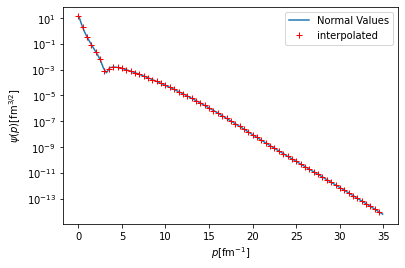

In [5]:
# determine interacion and set up solver 
data=get_values(1200)

# Get the Cubic Spline interpolation
cs = CubicSpline(data["p [fm-1]"], np.abs(data["wf [fm3/2]"]))
x_array=np.arange(data["p [fm-1]"][0], data["p [fm-1]"][len(data["p [fm-1]"])-1], 0.5)
if data["p [fm-1]"][0]>0:
    plt.semilogy(data["p [fm-1]"],np.abs(data["wf [fm3/2]"]),label="Normal Values")
else:  
    plt.semilogy(data["p [fm-1]"],np.abs(-data["wf [fm3/2]"]),label="Normal")
plt.semilogy(x_array, cs(x_array), "r+", label="interpolated")
plt.legend(loc="best")
plt.xlabel(r'$p$[fm$^{-1}$]')
plt.ylabel(r'$\psi(p)$[fm$^{3/2}$]')
plt.savefig("pictures/test.png", dpi=300)


plt.show()  
 

As we can see, the function is approximated well by the cubic spline. Therefore we will use this to solve the integral. Moreover, we can take a look at the expression $\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)$.

From the exercise sheet we know, that:

\begin{equation}
    \vec{p'}=\left(
    \begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x
    \end{array} \right) 
\end{equation}

and

\begin{equation}
    \vec{q}=\left(
    \begin{array}{c}
        0 \\ 
        0\\ 
        q
    \end{array} \right) 
\end{equation}

With $x=\cos(\theta)$. Moreover, as explained before, q is given as $\vec{q}=qe_z$

Therefore the expression $\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)$ becomes:

\begin{equation}
    \left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)= \left| \left(
    \begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x
    \end{array} \right) - 
    \frac{1}{2} \left(
    \begin{array}{c}
        0 \\ 
        0\\ 
        q
    \end{array} \right) \right| = 
    \left(
    \begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x -\frac{1}{2}q
    \end{array} \right)
    = \sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}
\end{equation}


This can be simplefied to:

\begin{equation}
    \sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}=\sqrt{p'^2 (1-x^2) + p'^2x^2 -\frac{1}{4}qp'x +\frac{1}{4}q^2} = \sqrt{p'^2- p'^2x^2 + p'^2x^2 -\frac{1}{4}qp'x +\frac{1}{4}q^2} = \sqrt{p'^2-\frac{1}{4}qp'x +\frac{1}{4}q^2}
\end{equation}

Now we can simplefy the Form factor to:

\begin{equation}
    F(q^2)=2 \pi \int dp' p'^2 \int_{-1}^{1} dx  \psi_{ll_z}(p')Y_{ll_z}(\hat{p'})\psi_{ll_z}\left(\sqrt{p'^2-\frac{1}{4}qp'x +\frac{1}{4}q^2}\right)Y_{ll_z} \hat{\left(\begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x -\frac{1}{2}q
    \end{array} \right)}
\end{equation}

Where 

\begin{equation}
    \hat{x}=\frac{\vec{x}}{|x|}
\end{equation} 

We see for $\vec{p'}$:

\begin{equation}
    |\vec{p'}|=\left| \left(
    \begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x
    \end{array} \right) \right|
    = \sqrt{(p' \sqrt{1-x^2})^2+0^2+(p' x)^2}=\sqrt{p'^2-p'^2x^2+p'^2 x^2}=p'
\end{equation}

And now we can see, that our spherical harmonics become:

\begin{equation}
    Y_{ll_z}(\hat{p'})=Y_{ll_z}\left(
    \hat{\begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x
    \end{array}} \right)=
    Y_{ll_z}\left(
    \begin{array}{c}
        \frac{p' \sqrt{1-x^2}}{p'} \\ 
        0\\ 
        \frac{p' x}{p'}
    \end{array} \right)=Y_{ll_z}\left(
    \begin{array}{c}
        \sqrt{1-x^2} \\ 
        0\\ 
        x
    \end{array} \right)
\end{equation}

Moreover we have already derived for $\left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)$:


\begin{equation}
    \left(|\vec{p}'-\frac{1}{2}\vec{q} |\right)= \left| \left(
    \begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x
    \end{array} \right) - 
    \frac{1}{2} \left(
    \begin{array}{c}
        0 \\ 
        0\\ 
        q
    \end{array} \right) \right| = 
    \left(
    \begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x -\frac{1}{2}q
    \end{array} \right)
    = \sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}
\end{equation}

and therefore we see:

\begin{equation}
    Y_{ll_z} \hat{\left(\begin{array}{c}
        p' \sqrt{1-x^2} \\ 
        0\\ 
        p' x -\frac{1}{2}q
    \end{array} \right)}
    =
    Y_{ll_z} \left(\begin{array}{c}
        \frac{p' \sqrt{1-x^2}}{\sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}} \\ 
        0\\ 
        \frac{p' x -\frac{1}{2}q}{\sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}}
    \end{array} \right)
\end{equation}






Thus we can see, that the integral of the form factor can be written as:

\begin{equation}
    F(q^2)=2 \pi \int dp' p'^2 \int_{-1}^{1} dx  \psi_{ll_z}(p')Y_{ll_z}\left(
    \begin{array}{c}
        \sqrt{1-x^2} \\ 
        0\\ 
        x
    \end{array} \right)\psi_{ll_z}\left(\sqrt{p'^2-\frac{1}{4}qp'x +\frac{1}{4}q^2}\right)Y_{ll_z} \left(\begin{array}{c}
        \frac{p' \sqrt{1-x^2}}{\sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}} \\ 
        0\\ 
        \frac{p' x -\frac{1}{2}q}{\sqrt{(p' \sqrt{1-x^2})^2+(p' x -\frac{1}{2}q)^2}}
    \end{array} \right)
\end{equation}

Which then becomes:

We can transform these equations, which are in the carthesian coordinates into spherical coordinates:

\begin{equation}

 r = \sqrt{x^2 + y^2 + z^2}, \\
 \varphi = \arctan(y/x), \\
 \theta = \arccos\left(\frac{z}{\sqrt{x^2 + y^2 + z^2}}\right) = \arccos\left(\frac{z}{r}\right)=\arctan\left(\frac{\sqrt{x^2+y^2}}{z}\right).

\end{equation}

In the end since we look at the spherical harmonics for l=0 and $l_z$=0 we choose to just use:

\begin{equation}
    Y_{00}=\frac{1}{\sqrt{4\pi}}
\end{equation}

Which simplefies our formfactor to:

Now we finally can calculate the form factor:

\begin{equation}
    F(q^2)=2 \pi \int dp' p'^2 \int_{-1}^{1} dx \frac{1}{4 \pi} \psi_{ll_z}\left(\sqrt{p'^2-\frac{1}{4}qp'x +\frac{1}{4}q^2}\right)Y_{ll_z} 
\end{equation}


For solving that form factor I want to introduce an nummerical integral: the simpsons rule. We devide the integral, which goes from a to b into N intervalls, which are next to each other. The result is then given by:

\begin{equation}
    \text{Integral}{(N)}(f)= \frac{h}{3}\left( f(x_0)+ 2 \sum_{k=1}^{N-1}f(x_{2k})+ f(x_{2N}) + 4\sum_{k=1}^{N}f(x_{2k-1}) \right)
\end{equation}

with h being 

\begin{equation}
    h = \frac{b-a}{N}
\end{equation}

So like many integration methods the simpsons rule splits up the space of the integration variable. It then summs up the results from the function based on a weight.

In [6]:
def simpson_test(start, end, points):
    h=(end-start)/points
    k=0.0
    x=start + h
    for i in range(1, int(points/2) + 1):
        k += 4*test_func(x)
        x += 2*h

    x = start + 2*h
    for i in range(1, int(points/2)):
        k += 2*test_func(x)
        x += 2*h
    return (h/3)*(test_func(start)+test_func(end)+k)

def test_func(x):
    return(x*x)

As a bechmark for the above mentioned function, we will execute the following integration:

\begin{equation}
    \int_0^3 x^2=\left[ \frac{1}{3} x^3\right]_0^3=9
\end{equation}

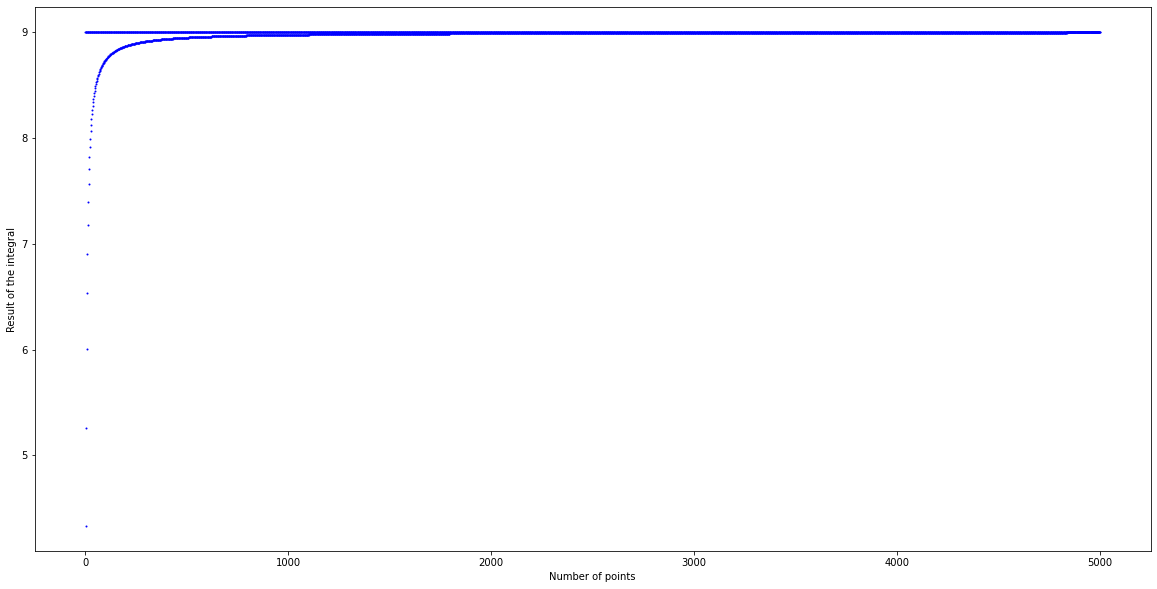

In [7]:
def test_simpsons_rule(start, end):
    x_array=np.arange(1, 5000, 1)
    y_array=np.zeros(len(x_array))
    for i in range(len(y_array)):
        y_array[i]=simpson_test(start, end, x_array[i])

    plt.figure(figsize=(20,10))
    plt.plot(x_array, y_array, "bo", markersize=1)
    plt.xlabel("Number of points")
    plt.ylabel("Result of the integral")
    plt.savefig("pictures/test_simpson.png", dpi=300)

test_simpsons_rule(0, 3)

We can see, that the value of the integral is alternating between the real value and a curve, that is slowly approaching the real value. Therefore we think we should take somewhere about 2000 grid points, because there the integral seems to be close to the real value. 

Now that we know, that this integral algorithm really works, we can use it for the spherical integral of the form factor. For that we have to define the definition again, because we don't know how to make the simpsons def more general.

In [8]:
# Integrate the spherical integral
def simpson(start, end, points, p, q, psi_p, spline):
    h=(end-start)/points
    k=0.0
    x=start + h
    for i in range(1, int(points/2) + 1):
        k += 4*function(x, p, q, psi_p, spline)
        x += 2*h

    x = start + 2*h
    for i in range(1, int(points/2)):
        k += 2*function(x, p, q, psi_p, spline)
        x += 2*h
    return (h/3)*(function(start, p, q, psi_p, spline)+function(end, p, q, psi_p, spline)+k)

def function(x, p, q, psi_p, spline):  
    # get the absolute value for p-1/2q, which was defined above
    Absolute_value_with_q=((p**2-(1/4)*q*p*x+(1/4)*q**2)**(1/2))

    # Interpolate psi with the cubic spline function
    psi = spline(Absolute_value_with_q)

    # We look at the angle between the x and z component by deviding the
    # z component by the x component (tangens)
    sperical_with_q=1/(4*m.pi)**(1/2)            

    # We do the same for the other spherical harmonic:
    sperical_without_q=1/(4*m.pi)**(1/2)     
         
    # return the product of these, so that we get the function in the spherical integral
    return psi*psi_p*sperical_with_q*sperical_without_q

Now we finally can calculate the form factor:

\begin{equation}
    F(q^2)=2 \pi \int dp' p'^2 \int_{-1}^{1} dx \frac{1}{4 \pi} \psi_{ll_z}\left(\sqrt{p'^2-\frac{1}{4}qp'x +\frac{1}{4}q^2}\right)Y_{ll_z} 
\end{equation}



In [9]:
def formfactor(q, Lambda, angular_grid=2001):
    integral=0
    data=get_values(Lambda)

    # Get the Cubic Spline interpolation
    cs = CubicSpline(data["p [fm-1]"], data["wf [fm3/2]"])

    y_array=np.zeros(len(data["p [fm-1]"]))

    for i in range(len(data["p [fm-1]"])):
        y_array[i] = simpson(-1, 1, angular_grid, data["p [fm-1]"][i], q, data["wf [fm3/2]"][i], cs)

    for i in range(len(data["p [fm-1]"])):
        integral = integral + (data["p [fm-1]"][i] ** 2 * data["w"][i] * y_array[i])

    return (2*3.14*integral)
print(formfactor(0, 1200, 2000))

0.9994931254072537


## 4: Use the wave function for $\Lambda = 1200MeV$ and selected momentum transfers $|\vec{q}|$ in the range up to $10fm^{−1}$ to check the numerical accuracy of your result, especially with respect to the number of grid points used for angular integration.

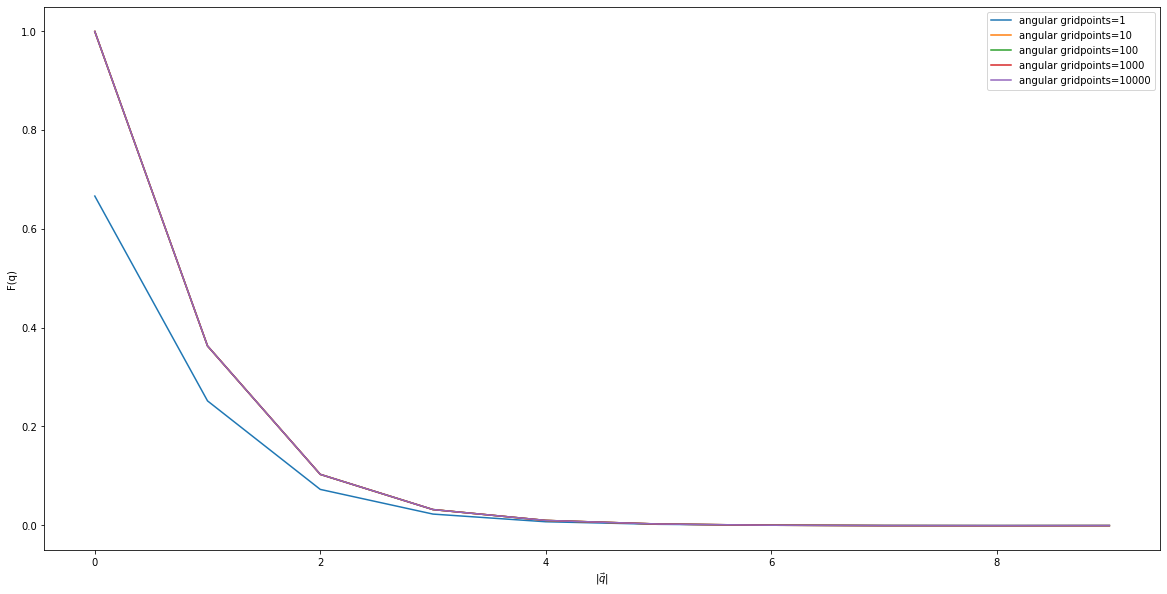

In [15]:
plt.figure(figsize=(20,10))

# We generate an array with the numbers of grid 
# points that we want to look at
gridpoint_array=[1, 10, 100, 1000, 10000]

# And an array with every q value that we
# want to inspect
q_array=np.arange(0, 10, 1)

# And an empty array where we will later store the form factors.
form_factor_array=np.zeros(len(q_array)*len(gridpoint_array)).reshape(len(gridpoint_array), len(q_array))

# Now we calculate the form factor for all combinations of gridpoints and q.
for gridpoints in range(len(gridpoint_array)):
    for q in range(len(q_array)):
        form_factor_array[gridpoints][q]=formfactor(q_array[q], 1200, gridpoint_array[gridpoints])

# Plotting the results
for form_factors in range(len(form_factor_array)):
    plt.plot(q_array, form_factor_array[form_factors], label=r"angular gridpoints={}".format(gridpoint_array[form_factors])) 
    
# Some cosmetics
plt.legend(loc="best")
plt.xlabel(r"$|\vec{q}|$")
plt.ylabel(r"F(q)")
plt.savefig("pictures/Gridpoints.png", dpi=300)

It seems that the result of the integral is correct starting at 10 gridpoints (assuming that all other lines are below the purple one fpr gridpoints=10000). This could be due to the effect, that we have observed in the picture where we tested the simpsons rule for different ammounts of grid points. The correctness of the integral there seemed to fluctuate between the actuall value and some value that was converging towards the acutal value. Maybe we got lucky and choose only values that delivered the correct integral.

However for the rest of the classwork we will choose gridpoints=2000 since it seems to be a point where the integral converges towards the point where the values that are not the actual correct results are very close to those, that are.

We want to try out if we can reproduce the behaviour from the example Integral $(x^2)$

In [ ]:
plt.figure(figsize=(20,10))

# We generate an array with the numbers of grid 
# points that we want to look at
gridpoint_array=[1, 11, 101, 1001, 10001]

# And an array with every q value that we
# want to inspect
q_array=np.arange(0, 10, 1)

# And an empty array where we will later store the form factors.
form_factor_array=np.zeros(len(q_array)*len(gridpoint_array)).reshape(len(gridpoint_array), len(q_array))

# Now we calculate the form factor for all combinations of gridpoints and q.
for gridpoints in range(len(gridpoint_array)):
    for q in range(len(q_array)):
        form_factor_array[gridpoints][q]=formfactor(q_array[q], 1200, gridpoint_array[gridpoints])

# Plotting the results
for form_factors in range(len(form_factor_array)):
    plt.plot(q_array, form_factor_array[form_factors], label=r"angular gridpoints={}".format(gridpoint_array[form_factors])) 
    
# Some cosmetics
plt.legend(loc="best")
plt.xlabel(r"$|\vec{q}|$")
plt.ylabel(r"F(q)")
plt.savefig("pictures/Gridpoints_but_different.png", dpi=300)

Here we can see the behaviour that was talked about before. Now that we changed nearly every ammount of gridpoints to the prior amount+1 we can see that the correct value is not always calculated. This seems to be the case where the fluctuations happen. However we can also see, that the difference between 1001 and 10001 is pretty small, and therefore we think that 2000 gridpoints are enough.

## 5: Show that F(0)=1 and $\frac{\partial F(\vec{q}^2)}{\partial \vec{q}^2} = -\frac{1}{6} \left< r^2 \right>$, where $\left< r^2 \right>$ is the expectation value of the square of the position of the first particle with respect to the center of mass. Confirm that your code reproduces the normalization of the form factor and the rms radius known from the Fourier transformation.

The form factor at q=0 should have the Taylor expansion 
\begin{equation}
    F(q^2)=1-\frac{1}{6}q^2r^2+cq^4+dq^6+...
\end{equation}

With that we can quickly see, that:

\begin{equation}
    F(0)=1
\end{equation}

and 

\begin{equation}
    \frac{\partial F(q^2)}{\partial q^2}=-\frac{1}{6}r^2
\end{equation}

[0.99949304 0.99949318 0.99949311 0.99949313]


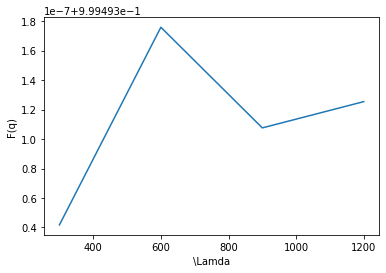

In [11]:
# We try out different lambda values in both cases:
lambda_array = [300, 600, 900, 1200]

# Initilize the form factor array
form_factor_array = np.zeros(len(lambda_array))

# And calculate the form factor of every lambda at q=0
for form_factors in range(len(form_factor_array)):
    form_factor_array[form_factors]=formfactor(0, lambda_array[form_factors])

# Now this is being plotted
print(form_factor_array)
plt.plot(lambda_array, form_factor_array)
plt.xlabel(r"\Lamda")
plt.ylabel(r"F(q)")
plt.savefig("pictures/Stability.png", dpi=300)
plt.savefig("pictures/F(0).png", dpi=300)

We don't know, why matplotlib decides to scale the y axis like this, but we see by looking at the values, that F(0) seems to be 1, as it should.

In [12]:
# Here we do something different. We calculate the derivitave of the form factor and
# the radii of our wave functions, since we want to see, if the above mentioned relations is correct 
q_array = np.arange(0, 9, 1)
form_factor_array = np.zeros(len(q_array))

""" The following part has been taken from the online lecture to get the radii of the wave functions """
pot=OBEpot(nx=24,mpi=138.0,C0=0.03431611357447293,A=-1.0/6.474860194946856,cutoff=1200)
solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                        nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                        np1four=400,np2four=200)
        
# perform energy search for this parameter set
ener,lam,pmom,wf=solver.esearch(neigv=1,e1=-2.0/TwoBody.hbarc,e2=-2.5/TwoBody.hbarc)
    
# get Fourier trafo (together with r grid points)
rp,wfr=solver.fourier(wf)
# calculate norm and rms radius (deviation of the norm from 1 gives idea of accuracy)
norm,rms=solver.rms(wfr)
""" From here we write our own code """

for q in range(len(q_array)):
        form_factor_array[q]=formfactor(q_array[q], 1200)

gmod = ExpressionModel("norm*(1.0-1./6.*rad**2*x**2+b*x**4+c*x**6)")
result = gmod.fit(form_factor_array, x=q_array, norm=1.0, rad=2.0, b=0,c=0)

print(result.fit_report()) 
print(norm, rms) 



[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 9
    # variables        = 4
    chi-square         = 0.28605526
    reduced chi-square = 0.05721105
    Akaike info crit   = -23.0391537
    Bayesian info crit = -22.2502554
[[Variables]]
    norm:  0.61875773 +/- 0.16060861 (25.96%) (init = 1)
    rad:   0.84984209 +/- 0.12328235 (14.51%) (init = 2)
    b:     0.00373016 +/- 0.00166012 (44.51%) (init = 0)
    c:    -3.2954e-05 +/- 1.8399e-05 (55.83%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c)   = -0.986
    C(rad, b) =  0.961
    C(rad, c) = -0.905
(0.9997840136459877+0j) (4.141728125349012+0j)


We can see, that the norm and the rad are not agreeing with the fitted result. Todo: Work on that 

## 6: Plot form factor for several $\Lambda$ in the range $\vec{q} = 0−10 fm^{-1}$ and briefly discuss differences and similarities at low and high momenta.

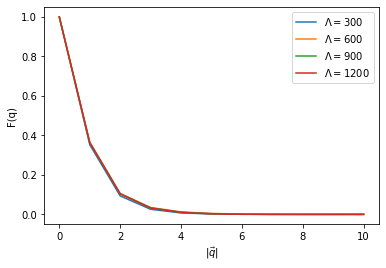

In [13]:
# Again we initilize the array
lambda_array = [300, 600, 900, 1200]

# We also introduce the possible q values that we want to look at
q_array=np.arange(0, 11, 1)

# And generate the empty array for the form factors
form_factor_array=np.zeros(len(q_array)*len(lambda_array)).reshape(len(lambda_array), len(q_array))

# Now we calculate the form factor for every combination of lambda and q
for lamda in range(len(lambda_array)):
    for q in range(len(q_array)):
        form_factor_array[lamda][q]=formfactor(q_array[q], lambda_array[lamda])

# And we plot them, to visualize the difference between high and low energy regions.
for form_factors in range(len(form_factor_array)):
    plt.plot(q_array, form_factor_array[form_factors], label=r"$\Lambda=${}".format(lambda_array[form_factors])) 
plt.legend(loc="best")
plt.xlabel(r"$|\vec{q}|$")
plt.ylabel(r"F(q)")
plt.savefig("pictures/Formfactors.png", dpi=300)